In [1]:
# run under DIP environment
import os
import skimage.io as io
import scipy.io as sio
import numpy as np
import time

## Load Data

DD_PARS_blood (from out lab)

In [20]:
file_name  = 'data\DD_PARS\DD_PARS_blood.mat'
mat = sio.loadmat(file_name)
print(mat.keys())
img_down = mat["DD_PARS_blood"]
print(img_down)

dict_keys(['__header__', '__version__', '__globals__', 'DD_PARS_blood'])
[[-0.00281703  0.04474869  0.07806052 ...  0.20813947  0.09892211
   0.17973029]
 [-0.00358088  0.04588338  0.19479143 ...  0.15374348  0.09316964
   0.2306272 ]
 [-0.00323607  0.04219283  0.12779176 ...  0.18422623  0.18974474
   0.18660891]
 ...
 [ 0.0405782   0.04044068 -0.01404143 ...  0.11650213  0.15620839
   0.10859799]
 [ 0.06482545  0.05712567  0.01334614 ...  0.04554598  0.0021555
   0.00477221]
 [ 0.04727308  0.12854767  0.01879105 ... -0.00354247  0.15604256
   0.11619125]]


In [3]:
from utils.expand_data import *
img_masked, img_mask = expand_data(img_down, 128, 128)

Plot the loaded data

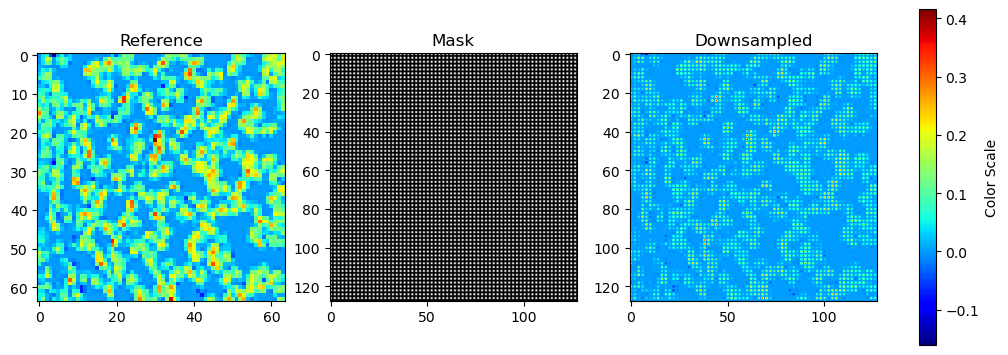

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

colormap = 'jet'
# plot each image
im1 = axes[0].imshow(img_down, cmap=colormap)
axes[0].set_title("Reference")

im2 = axes[1].imshow(img_mask, cmap = 'gray')
axes[1].set_title("Mask")

im3 = axes[2].imshow(img_masked,cmap=colormap)
axes[2].set_title("Downsampled")

# add colorbars
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Color Scale")

plt.show()


## Pre-work of DIP

In [5]:
import torch
import torch.optim
torch.__version__

'2.0.1'

Set inputs, hyperparameters and network architecture

In [6]:
img_np = np.expand_dims(img_masked, 0)  # expand the downsampled image to 3D numpy array (1, H, W)
mask_np = np.expand_dims(img_mask, 0)   # expand the mask to 3D numpy array (1, H, W)

from models.skip import skip
from utils.inpainting_utils import *

#from skimage.measure import compare_psnr,compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# setup
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.001 
num_iter = 1000
param_noise = False
show_every = 50
save_every = 10
figsize = 5
reg_noise_std = 0.03
    
net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5,
           num_channels_up =   [128] * 5,
           num_channels_skip =    [4] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='bilinear', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype) # generate a random noise input tensor (1, input_depth, H, W)
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)   # convert numpy array to torch tensor (1, 1, H, W)
mask_var = np_to_torch(mask_np).type(dtype) # convert numpy array to torch tensor (1, 1, H, W)


Number of params: 2217573


Create the numpy to save the reults for each [save_every] iteration and processing time (in second)

In [7]:
out_log_np = np.zeros(shape = (num_iter//save_every, img_masked.shape[0], img_masked.shape[1]))
time_log_np = np.zeros(shape = (1, num_iter//save_every))

show the input noise

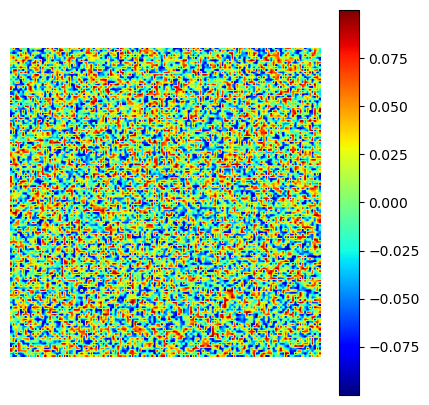

In [8]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(torch_to_np(net_input).transpose(1, 2, 0)[:,:,0], cmap='jet')   
plt.colorbar()

# DIP process

Starting optimization with ADAM


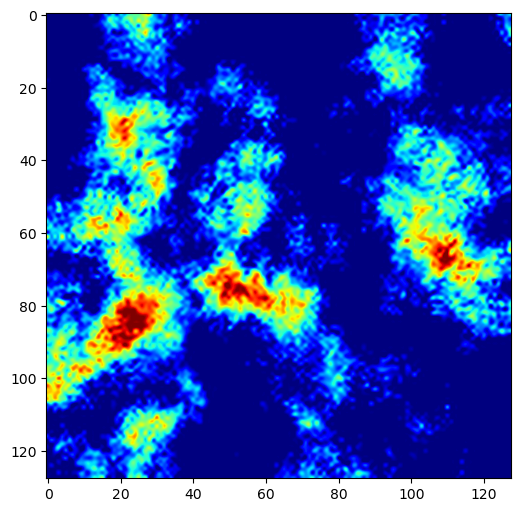

Elasped time:21.105
Elasped time:21.758Loss 0.002303    PSNR 20.653565    SSIM 0.098376 
Elasped time:22.145Loss 0.001550    PSNR 22.566647    SSIM 0.130077 
Elasped time:22.604Loss 0.001357    PSNR 23.114361    SSIM 0.152890 
Elasped time:23.034Loss 0.001223    PSNR 23.202767    SSIM 0.144838 


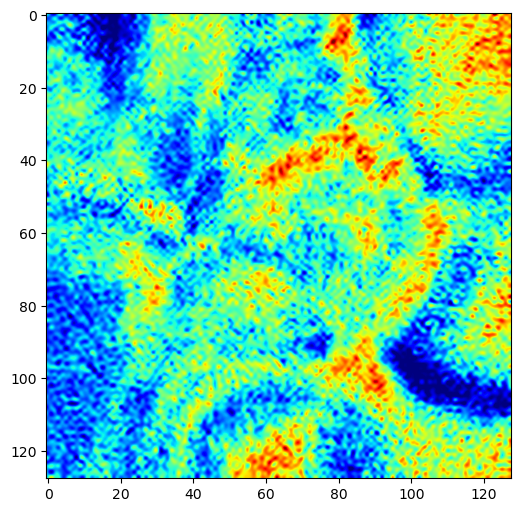

Elasped time:24.132
Elasped time:24.587Loss 0.001111    PSNR 23.313366    SSIM 0.155091 
Elasped time:25.027Loss 0.001065    PSNR 23.449458    SSIM 0.165185 
Elasped time:25.446Loss 0.001026    PSNR 23.363022    SSIM 0.168699 
Elasped time:25.869Loss 0.000987    PSNR 23.334433    SSIM 0.173341 


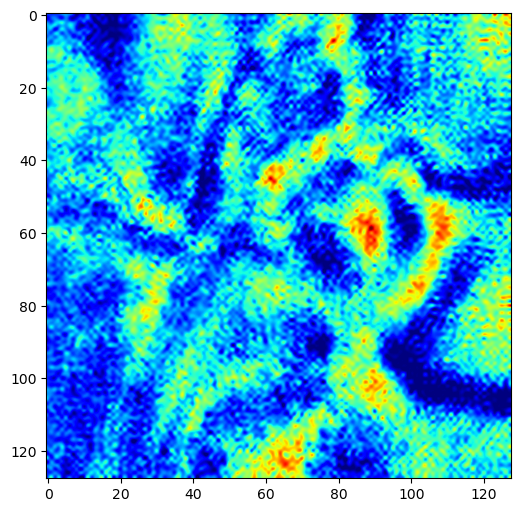

Elasped time:26.933
Elasped time:27.366Loss 0.000917    PSNR 23.193374    SSIM 0.181613 
Elasped time:27.8  Loss 0.000885    PSNR 23.185675    SSIM 0.186814 
Elasped time:28.222Loss 0.000848    PSNR 23.180140    SSIM 0.193373 
Elasped time:28.655Loss 0.000797    PSNR 23.131293    SSIM 0.200378 


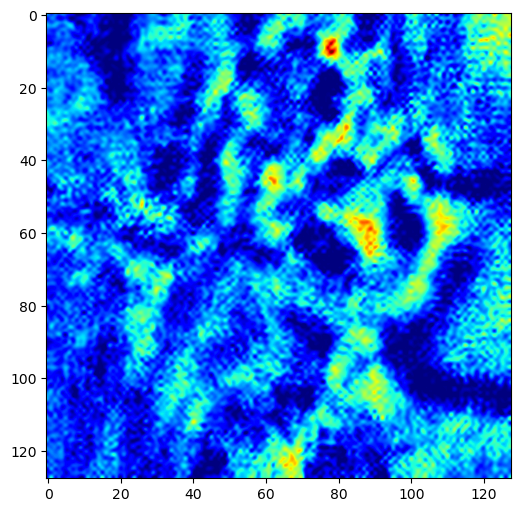

Elasped time:29.696
Elasped time:30.143Loss 0.000736    PSNR 23.013272    SSIM 0.211669 
Elasped time:30.566Loss 0.000707    PSNR 22.971615    SSIM 0.208826 
Elasped time:31.024Loss 0.000673    PSNR 22.864052    SSIM 0.214731 
Elasped time:31.441Loss 0.000643    PSNR 22.745307    SSIM 0.218493 


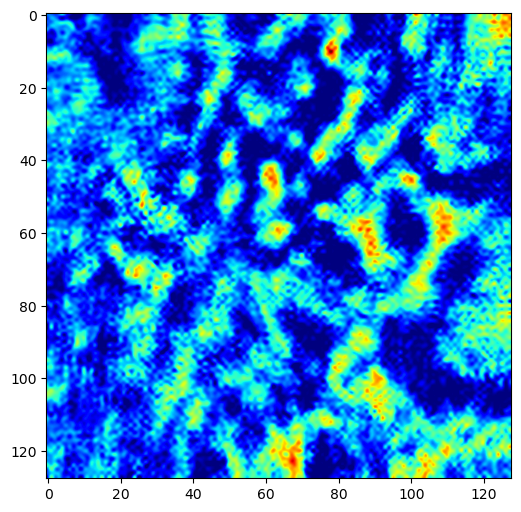

Elasped time:32.454
Elasped time:32.923Loss 0.000580    PSNR 22.582691    SSIM 0.222221 
Elasped time:33.316Loss 0.000558    PSNR 22.570408    SSIM 0.214659 
Elasped time:33.768Loss 0.000534    PSNR 22.548180    SSIM 0.221683 
Elasped time:34.193Loss 0.000484    PSNR 22.556190    SSIM 0.228174 


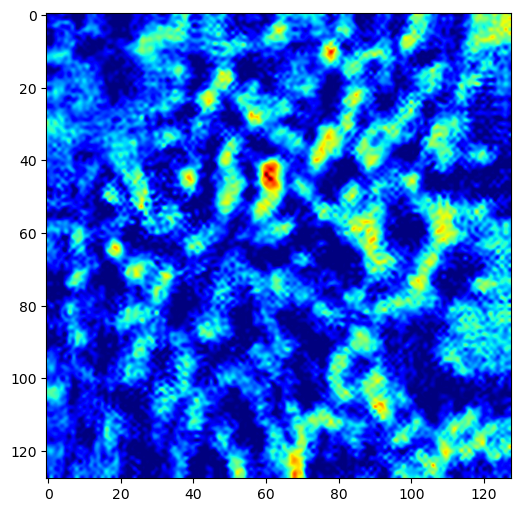

Elasped time:35.245
Elasped time:35.668Loss 0.000465    PSNR 22.383325    SSIM 0.229897 
Elasped time:36.101Loss 0.000445    PSNR 22.451384    SSIM 0.232301 
Elasped time:36.552Loss 0.000482    PSNR 22.148644    SSIM 0.225158 
Elasped time:37.022Loss 0.000382    PSNR 22.381582    SSIM 0.237678 


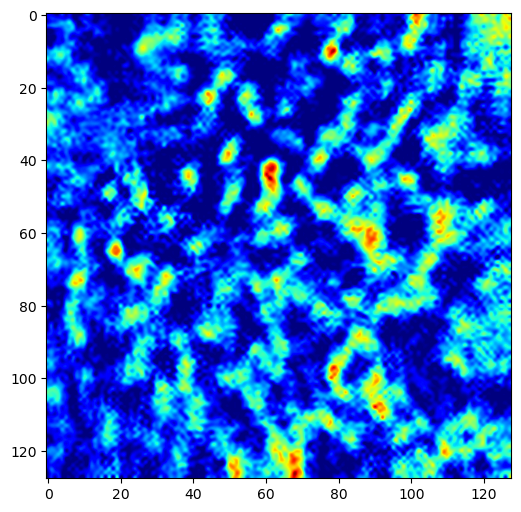

Elasped time:39.257
Elasped time:39.71 Loss 0.000368    PSNR 22.252679    SSIM 0.238154 
Elasped time:40.104Loss 0.000357    PSNR 22.260400    SSIM 0.236392 
Elasped time:40.524Loss 0.000352    PSNR 22.149086    SSIM 0.237376 
Elasped time:40.933Loss 0.000318    PSNR 22.254058    SSIM 0.234685 


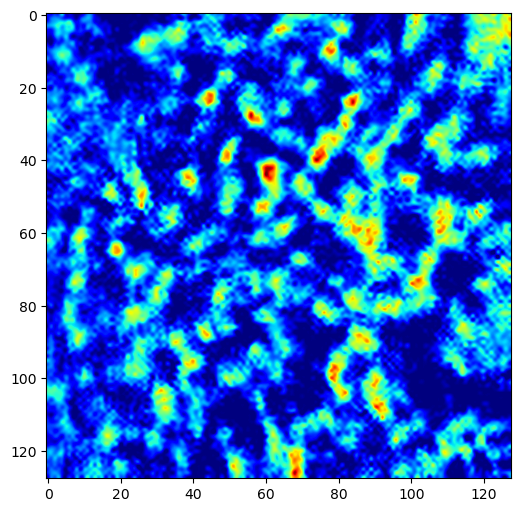

Elasped time:41.939
Elasped time:42.332Loss 0.000311    PSNR 22.344458    SSIM 0.238570 
Elasped time:42.751Loss 0.000302    PSNR 22.167013    SSIM 0.242880 
Elasped time:43.132Loss 0.000315    PSNR 22.204710    SSIM 0.231976 
Elasped time:43.5  Loss 0.000317    PSNR 22.094911    SSIM 0.248916 


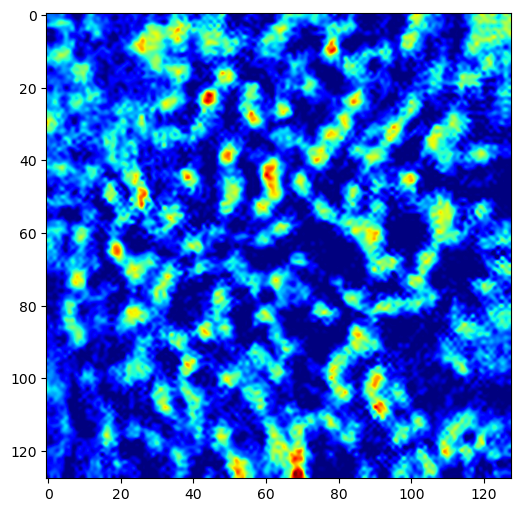

Elasped time:44.52
Elasped time:44.944Loss 0.000272    PSNR 22.059631    SSIM 0.234209 
Elasped time:45.397Loss 0.000298    PSNR 22.030466    SSIM 0.235311 
Elasped time:45.805Loss 0.000256    PSNR 22.084713    SSIM 0.239971 
Elasped time:46.203Loss 0.000226    PSNR 22.206256    SSIM 0.249106 


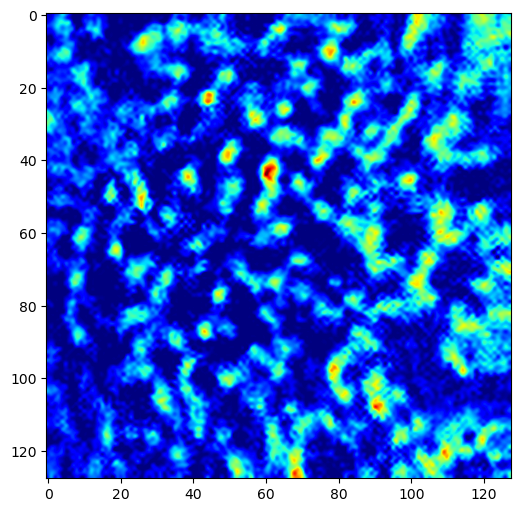

Elasped time:47.175
Elasped time:47.562Loss 0.000225    PSNR 22.152761    SSIM 0.247373 
Elasped time:47.959Loss 0.000211    PSNR 22.190070    SSIM 0.244978 
Elasped time:48.35 Loss 0.000308    PSNR 21.845951    SSIM 0.240346 
Elasped time:48.729Loss 0.000213    PSNR 22.000233    SSIM 0.240033 


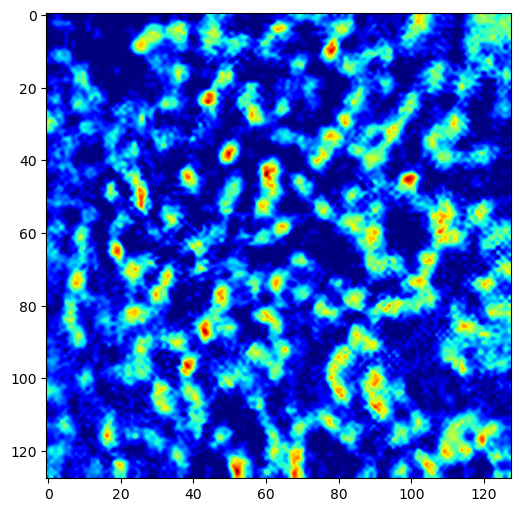

Elasped time:49.721
Elasped time:50.121Loss 0.000209    PSNR 21.992477    SSIM 0.243518 
Elasped time:50.503Loss 0.000232    PSNR 22.071282    SSIM 0.243975 
Elasped time:50.881Loss 0.000196    PSNR 22.091767    SSIM 0.253883 
Elasped time:51.312Loss 0.000221    PSNR 21.914006    SSIM 0.245901 


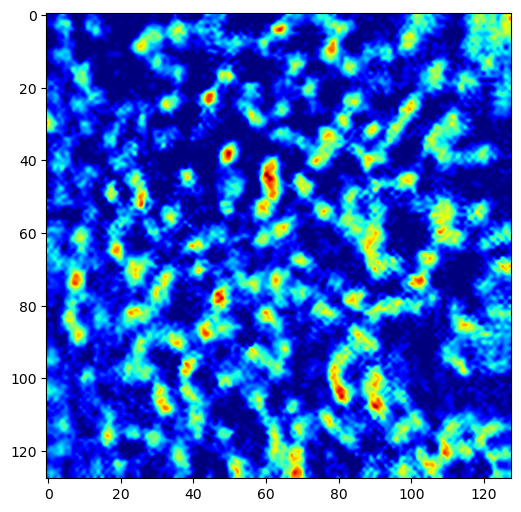

Elasped time:52.288
Elasped time:52.707Loss 0.000171    PSNR 22.055103    SSIM 0.259737 
Elasped time:53.082Loss 0.000221    PSNR 21.956150    SSIM 0.250153 
Elasped time:53.464Loss 0.000209    PSNR 22.043812    SSIM 0.248694 
Elasped time:53.843Loss 0.000172    PSNR 21.964313    SSIM 0.256225 


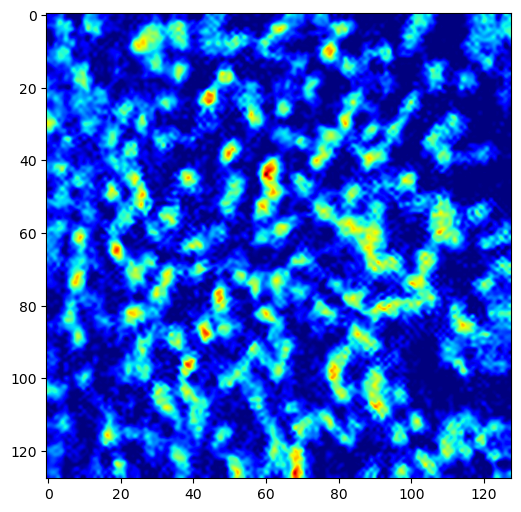

Elasped time:54.783
Elasped time:55.21 Loss 0.000165    PSNR 21.999632    SSIM 0.255270 
Elasped time:55.632Loss 0.000285    PSNR 21.748299    SSIM 0.233652 
Elasped time:56.04 Loss 0.000185    PSNR 22.013740    SSIM 0.251408 
Elasped time:56.428Loss 0.000165    PSNR 22.027127    SSIM 0.252069 


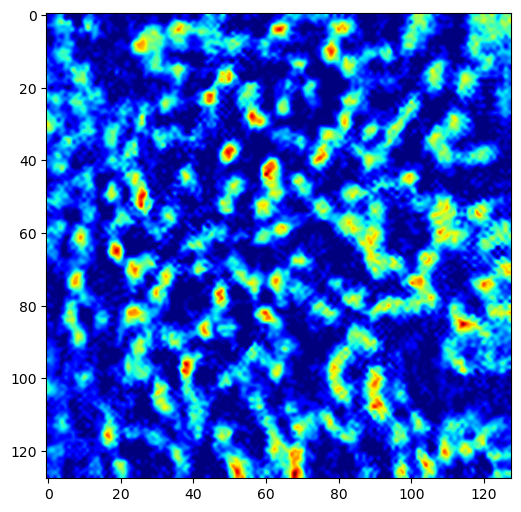

Elasped time:57.37
Elasped time:57.792Loss 0.000152    PSNR 22.032750    SSIM 0.253017 
Elasped time:58.181Loss 0.000144    PSNR 22.035510    SSIM 0.260809 
Elasped time:58.57 Loss 0.000147    PSNR 22.048101    SSIM 0.259339 
Elasped time:59.018Loss 0.000150    PSNR 21.945538    SSIM 0.253374 


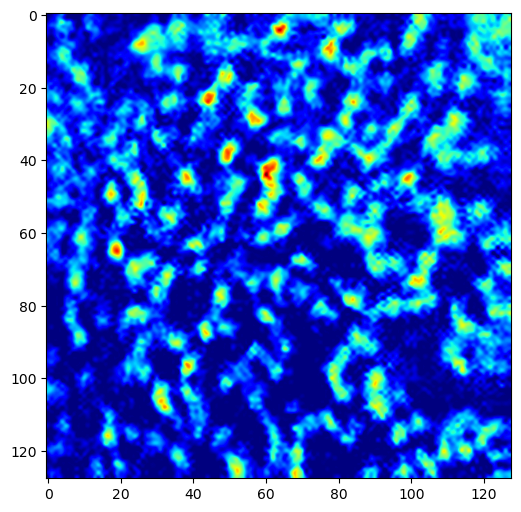

Elasped time:59.973
Elasped time:60.409Loss 0.000198    PSNR 21.926609    SSIM 0.249885 
Elasped time:60.799Loss 0.000134    PSNR 22.020361    SSIM 0.258996 
Elasped time:61.188Loss 0.000177    PSNR 21.945272    SSIM 0.250468 
Elasped time:61.573Loss 0.000144    PSNR 21.932704    SSIM 0.255407 


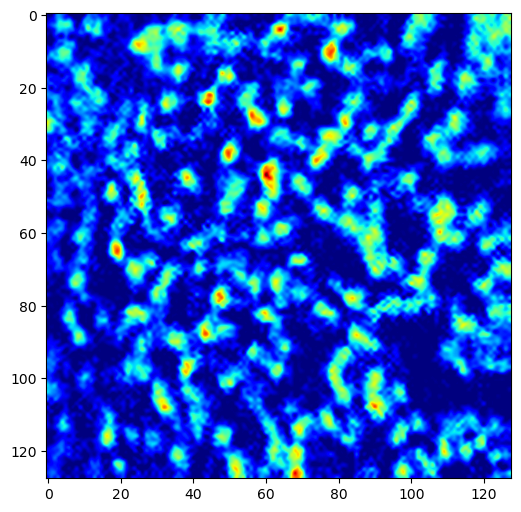

Elasped time:62.563
Elasped time:63.085Loss 0.000130    PSNR 22.014181    SSIM 0.262831 
Elasped time:63.51 Loss 0.000132    PSNR 21.979615    SSIM 0.259553 
Elasped time:63.982Loss 0.000124    PSNR 21.961858    SSIM 0.265962 
Elasped time:64.41 Loss 0.000142    PSNR 21.857950    SSIM 0.261491 


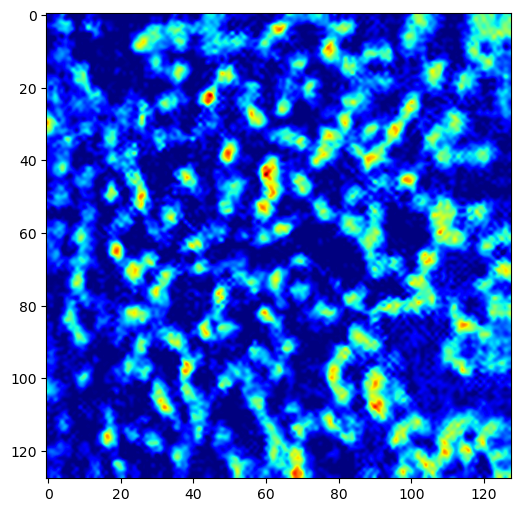

Elasped time:65.45
Elasped time:65.862Loss 0.000113    PSNR 22.096628    SSIM 0.263627 
Elasped time:66.265Loss 0.000106    PSNR 22.018800    SSIM 0.263358 
Elasped time:66.674Loss 0.000121    PSNR 22.158535    SSIM 0.267578 
Elasped time:67.06 Loss 0.000119    PSNR 22.037540    SSIM 0.251935 


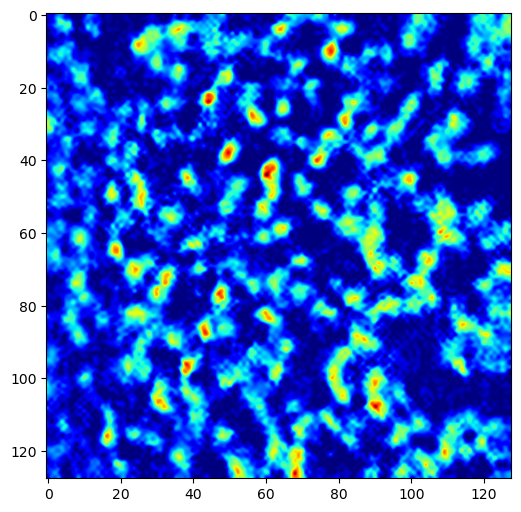

Elasped time:68.051
Elasped time:68.471Loss 0.000108    PSNR 22.038106    SSIM 0.264248 
Elasped time:68.884Loss 0.000115    PSNR 22.006921    SSIM 0.256462 
Elasped time:69.265Loss 0.000130    PSNR 21.943975    SSIM 0.262053 
Elasped time:69.655Loss 0.000108    PSNR 22.014045    SSIM 0.263171 


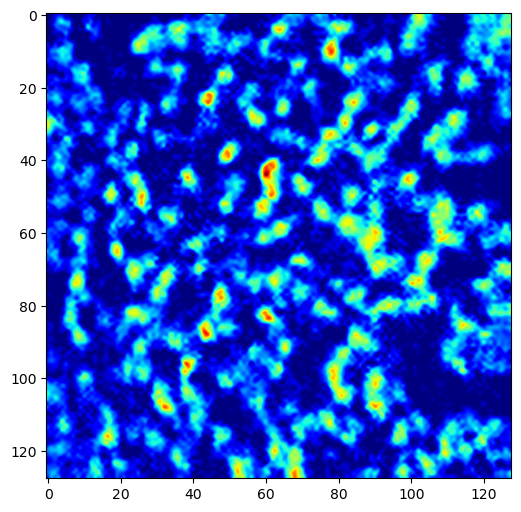

Elasped time:70.663
Elasped time:71.096Loss 0.000136    PSNR 22.019933    SSIM 0.266338 
Elasped time:71.512Loss 0.000123    PSNR 21.911352    SSIM 0.265089 
Elasped time:72.123Loss 0.000107    PSNR 21.917918    SSIM 0.259252 
Elasped time:72.755Loss 0.000117    PSNR 21.908498    SSIM 0.259398 


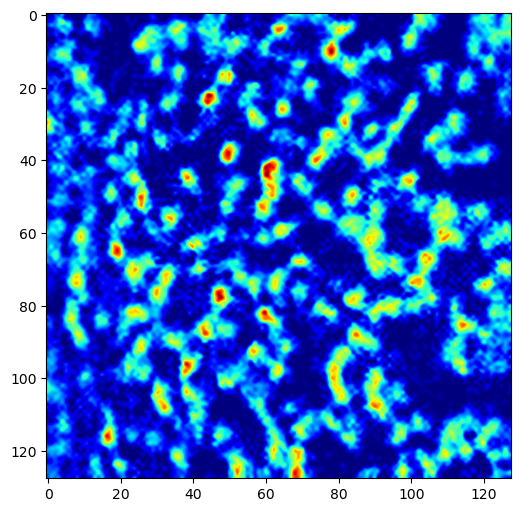

Elasped time:74.158
Elasped time:74.635Loss 0.000100    PSNR 21.931460    SSIM 0.266855 
Elasped time:75.052Loss 0.000091    PSNR 22.023497    SSIM 0.262579 
Elasped time:75.488Loss 0.000121    PSNR 21.964533    SSIM 0.261101 
Elasped time:75.894Loss 0.000091    PSNR 21.935464    SSIM 0.263019 


In [9]:
i = 0
psnr_history = [] 
loss_history = [] 
ssim_history = []
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)    # output of network (1, 1, H, W)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    psnr = compare_psnr(img_np, torch_to_np(out), data_range = 1.0)
    ssim = compare_ssim(img_np[0,:], torch_to_np(out)[0,:], data_range = 1.0)
    # History
    loss_history.append(total_loss.item())
    psnr_history.append(psnr)
    ssim_history.append(ssim)

    print ('Iteration %05d    Loss %f    PSNR %f    SSIM %f' % (i, total_loss.item(), psnr, ssim), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)   
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
    if i % save_every == 0:
        out_np = torch_to_np(out)[0,:]
        out_log_np[i//save_every, :, :] = out_np
        print(f'Elasped time:{round(time.time() - start_time, 3)}')
        time_log_np[0, i//save_every] = round(time.time() - start_time, 3)
    i += 1
    return total_loss

start_time = time.time()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Show the final output of DIP

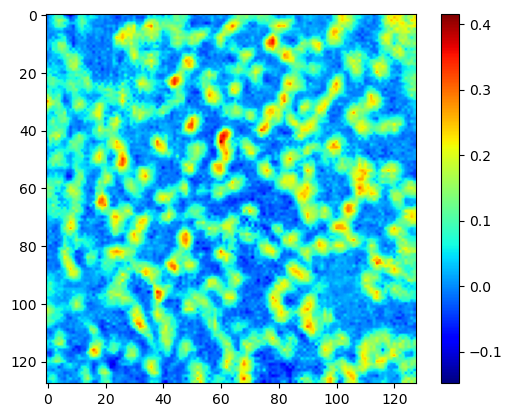

In [15]:
img_out = torch_to_np(net(net_input))[0,:]
plt.imshow(img_out, cmap='jet')
plt.colorbar()

Text(0.5, 1.0, 'Reconstructed')

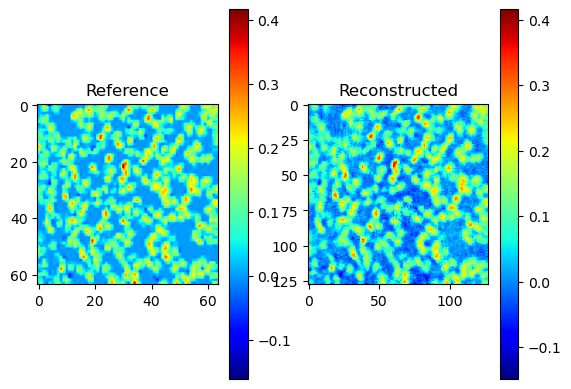

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(img_down, cmap='jet')
plt.colorbar()
plt.title('Reference')
plt.subplot(1, 2, 2)
plt.imshow(img_out, cmap='jet')
plt.colorbar()
plt.title('Reconstructed')

In [13]:
print(f'Reference minimum: \t{img_down.min()},\tmaximum: {img_down.max()}')
print(f'Reconstructed minimum: \t{img_out.min()},\tmaximum: {img_out.max()}')

Reference minimum: 	-0.1607808300788482,	maximum: 0.4161385149253625
Reconstructed minimum: 	-0.1483597755432129,	maximum: 0.41583767533302307


In [14]:
torch.cuda.empty_cache()